In [7]:
import numpy as np
import numpy.lib.stride_tricks as ns
import cv2
import imageio
import skimage.color as skc
import skimage.filters as skf
import matplotlib.pyplot as plt

In [3]:
sigma_s = 2
sigma_r = 3

In [12]:
def bilateral_gaussian(im):
    # Radius of the Gaussian filter
    r = int(2 * sigma_s) + 1
    padded = np.pad(im, ((r, r), (r, r), (0, 0)), 'edge')
    '''
    Implement the bilateral Gaussian filter (Eq. 3).
    Apply it to the padded image.
    '''


    windows = ns.sliding_window_view(padded , (2*r+1, 2*r+1, 3)) # Napravice array (400, 254, 1, 17,17,3), u sustini prva dva broja su mesto piksela, ostatak je sam prozor. 
    chnanel_diff = windows - im[:, :, None, None, None, :] # Oduzmem od svakog prozora centralni piksel, ovo bi trebalo da radi. 
    luminance_magnitude = np.sqrt(np.sum((chnanel_diff ** 2), axis=-1)) # Izracunam L2 normu te razlike. 
    luminance_magnitude = np.exp(-luminance_magnitude**2 / (2.0*sigma_s**2)) # Ukoliko ovo prethodno radi imacemo (400, 254, 1, 17, 17). tj onaj deo |F(p) - F(q)|_f u zadatku. 

    indices = np.indices((2*r+1, 2*r+1)) + 1  
    pixels = np.stack(indices, axis=-1) 
    pixels = pixels - pixels[r,r,:] # Meni nesto deluje da svaki prozor kada je razlika piksela u pitanju je uvek isti prozor. I onda mi je ideja da ovo izracunamo samo jednom 
                                    # i posle da ne moramo uopste. 

    pixels_magnitude = np.linalg.norm(pixels, axis=-1, ord=2, keepdims=False) # Izracunam L_inf normu, nisam siguran za ovaj keep dims, ali dobije se taman (17,17) sto mozemo samo 
                                                                                   # da pomnozimo sa luminance magnitude.
    pixels_magnitude = np.exp(-pixels_magnitude**2/ (2.0*sigma_r**2)) # Po formuli opet fali /2

    weights =  pixels_magnitude * luminance_magnitude # Pomnozimo ih ovo bi trebalo da bude b(|p-q|_inf)b(|F(p) - F(q)|_f) za svaki prozor. 
    sum_weights = np.sum(weights, axis=(-1,-2, -3)) # Sumiramo, to je delioc u onoj formuli. 
    
    filtered = weights[..., None] * windows # b(|p-q|_inf)b(|F(p) - F(q)|_f) * F(q)
    filtered = np.sum(filtered, axis=(-2, -3, -4)) / sum_weights[..., None] # Sumiramo sve prozore, i izbacimo onu jedinicu u (400, 254, 1 ...)

    return filtered 

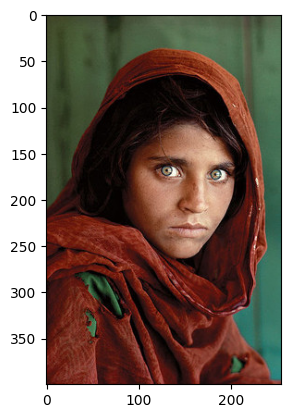

In [14]:
im = imageio.imread('girl.png')
plt.imshow(im)

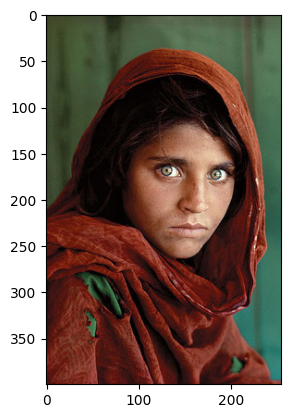

In [15]:
opencv2 = cv2.bilateralFilter(im, int(2 * sigma_s) + 1, sigma_s, sigma_r)
plt.imshow(opencv2)

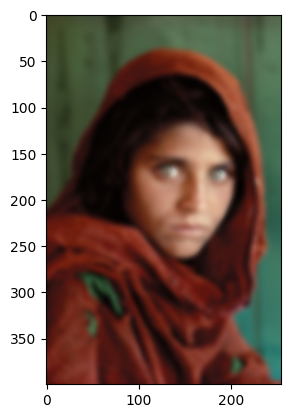

In [18]:
im2 = im / 255.
nas = bilateral_gaussian(im2)
plt.imshow(nas)

/tmp/ipykernel_72377/2924946717.py:1: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  plt.imshow(skf.gaussian(im2, sigma=sigma_r))


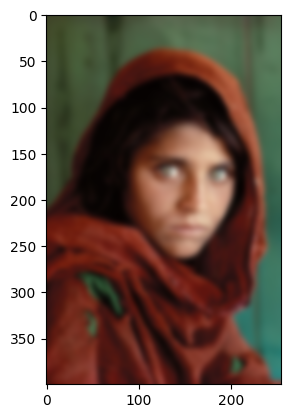

In [21]:
plt.imshow(skf.gaussian(im2, sigma=sigma_r))